# Frequenzsweep

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import linecache
from scipy.signal import find_peaks
from scipy.stats import linregress

In [54]:
class Oszi:
    def __init__(self,path):
        '''Path ohne Endung angeben.'''
        data = np.genfromtxt(path).T
        self.path = path
        self.scope = path + '_ScopeSettings.txt'
        self.time = data[0]
        self.ch1 = data[1]
        self.ch2 = data[2]

    def plot(self,xlabel=None,ylabel1=None,ylabel2=None,title=None,figsize=(8,5),ScopeSettings=False):
        '''ScopeSettings gibt an, ob Oszi-Fenster wie im Praktikum dargestellt werden soll.'''
        fig, ax1 = plt.subplots(figsize=figsize)
        ax2 = ax1.twinx()
        if ScopeSettings == True:
            '''Bin mir nicht ganz sicher, ob das so passt. Wahrscheinliche automatische Anpassung besser'''
            offset1 = float(linecache.getline(self.scope,3).split()[1])
            # scale1 = float(linecache.getline(self.scope,2).split()[1])
            offset2 = float(linecache.getline(self.scope,11).split()[1])
            # scale2 = float(linecache.getline(self.scope,10).split()[1])
            print(offset1)
            print(offset2)
            ax1.plot(self.time,self.ch1+offset1,label='Channel 1',color='blue')
            ax2.plot(self.time,self.ch2+offset2,label='Channel 2',color='red')
            ax1.legend(loc=2)
            ax2.legend(loc=3)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')
        else:
            ax1.plot(self.time,self.ch1,label='Channel 1',color='blue')
            ax2.plot(self.time,self.ch2,label='Channel 2',color='red')
            ax1.legend(loc=2)
            ax2.legend(loc=3)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax2.tick_params(axis='y', labelcolor='red')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel1,c='blue')
        ax2.set_ylabel(ylabel2,c='red')
        plt.title(title)
        return fig, ax1, ax2

def helmholtz(N,r,I):
    '''Rückgabe der magnetischen Flussdichte'''
    return (4/5)**(3/2)*N/r*I

R = 1/0.5806117775757463
N = 160
r = 9e-2

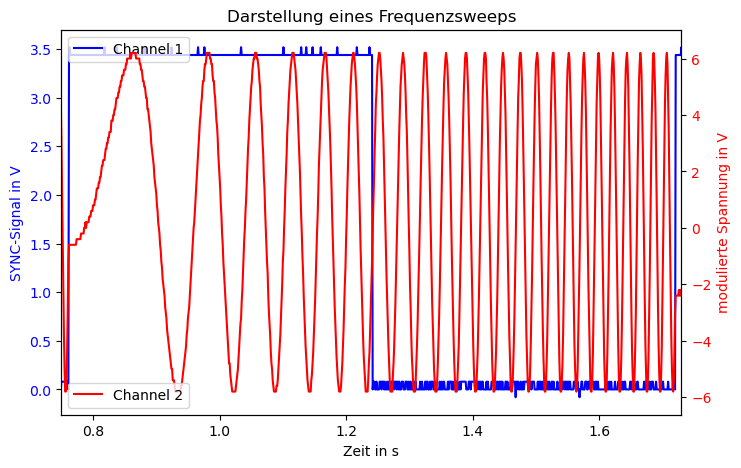

In [55]:
test = Oszi('data/g_faktor/f_sweep/sync_test')
fig, ax1, ax2 = test.plot(title='Darstellung eines Frequenzsweeps',xlabel='Zeit in s',ylabel1='SYNC-Signal in V',ylabel2='modulierte Spannung in V')
plt.xlim(0.75,1.73)
plt.savefig('figures/frequenzsweep.pdf')

Messung für 25 V fehlt!!!

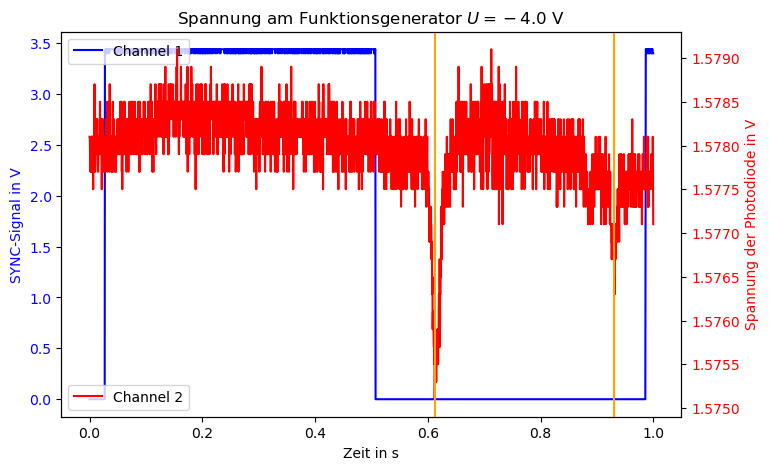

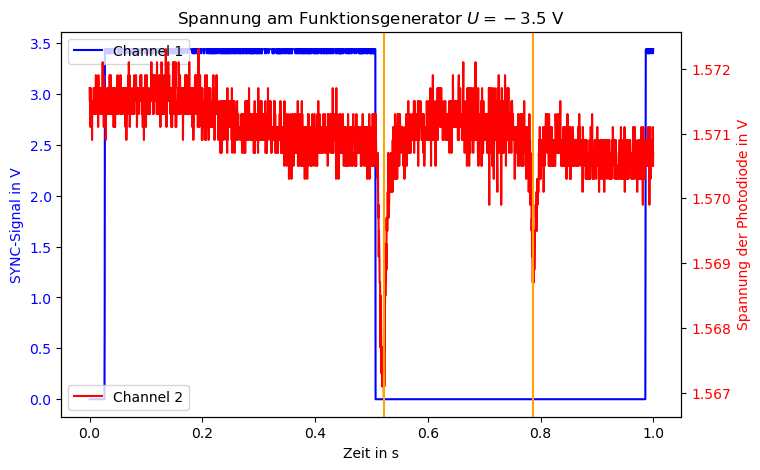

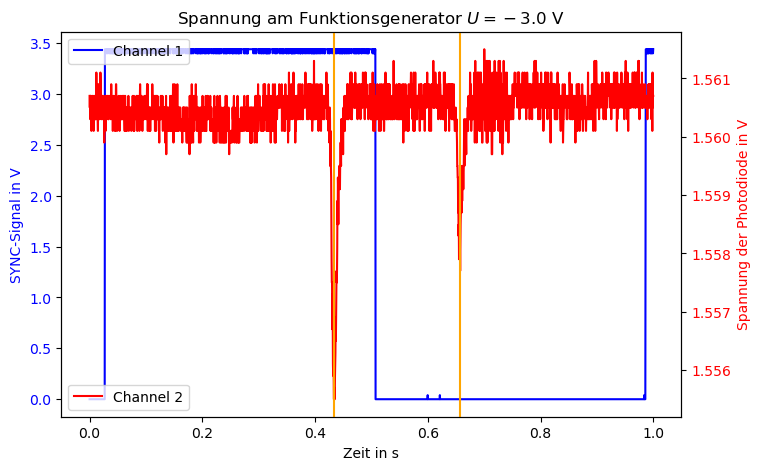

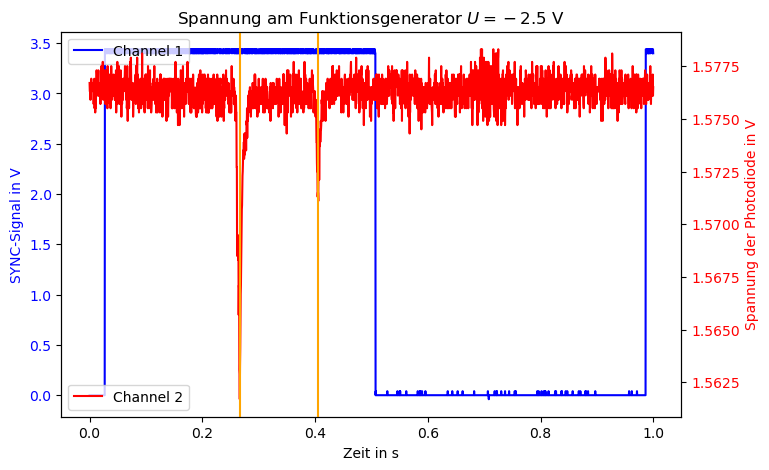

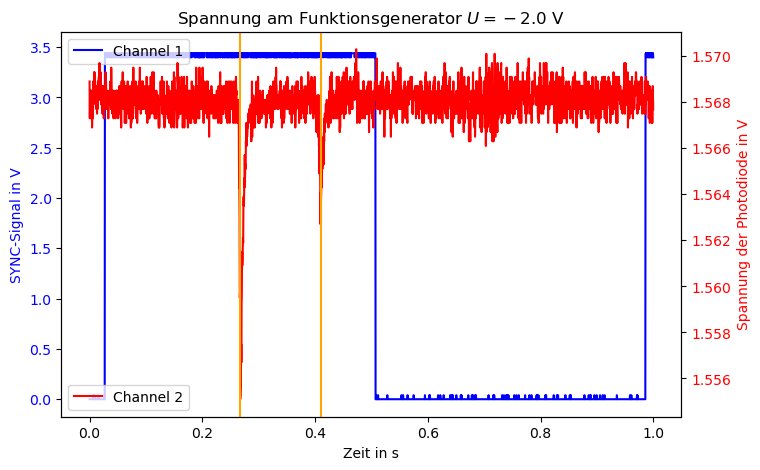

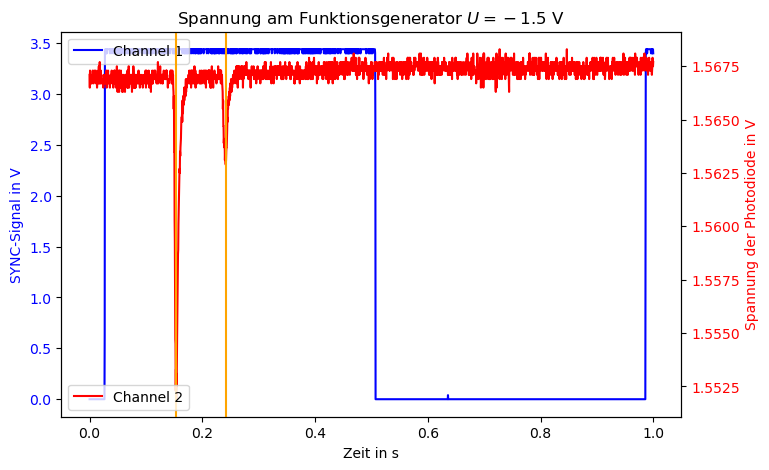

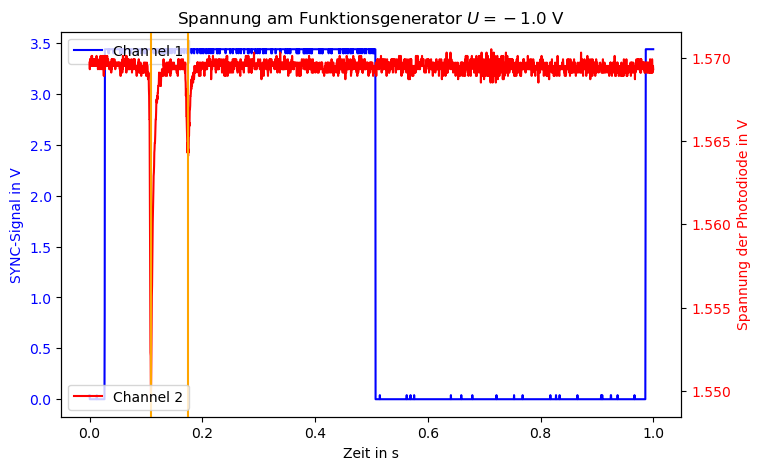

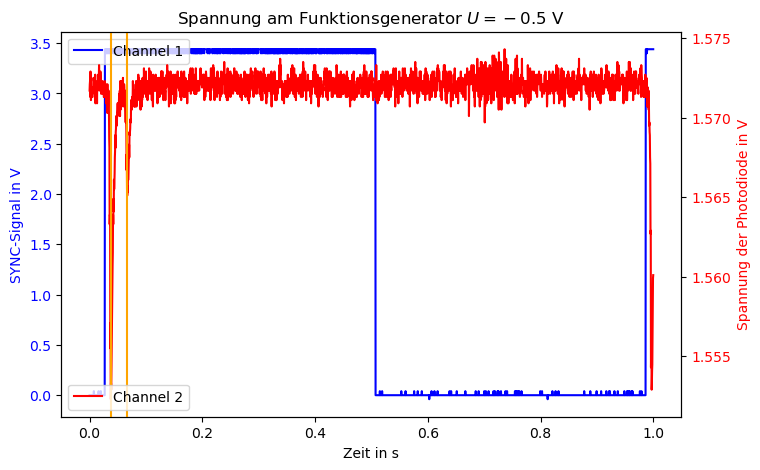

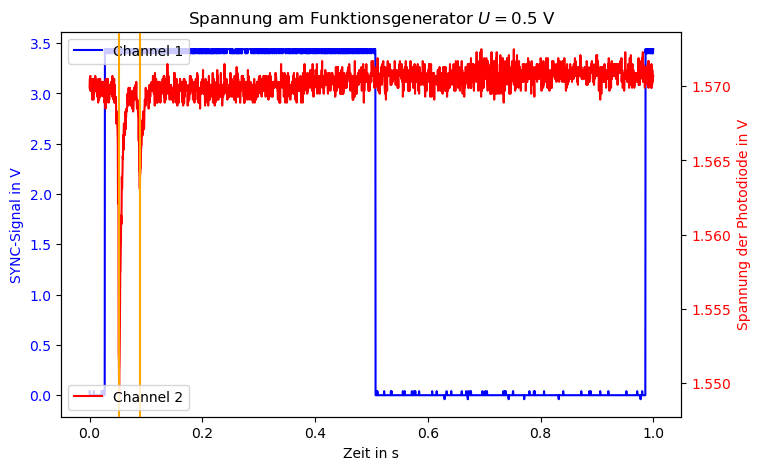

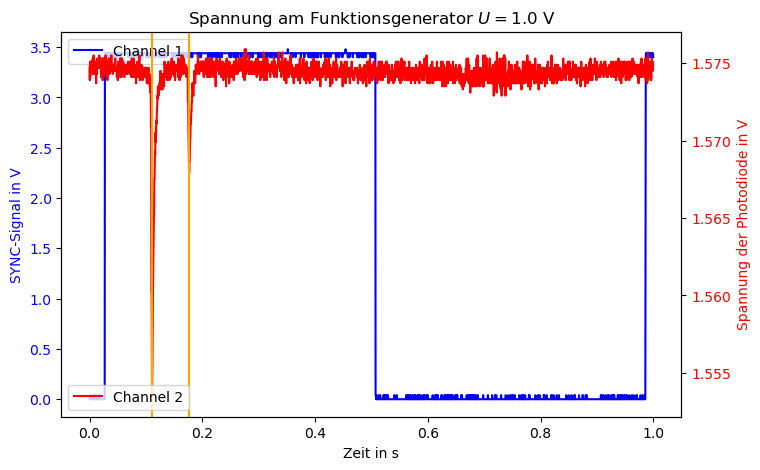

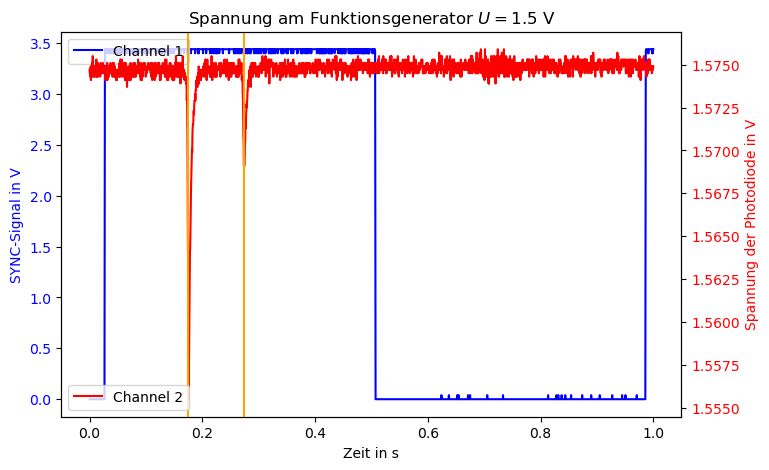

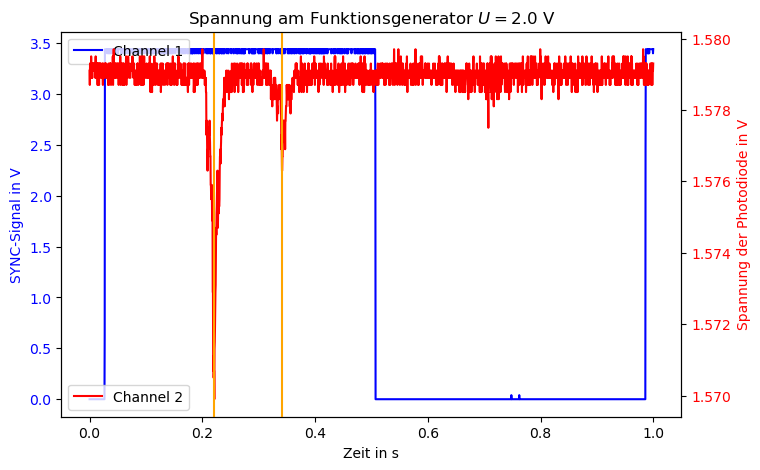

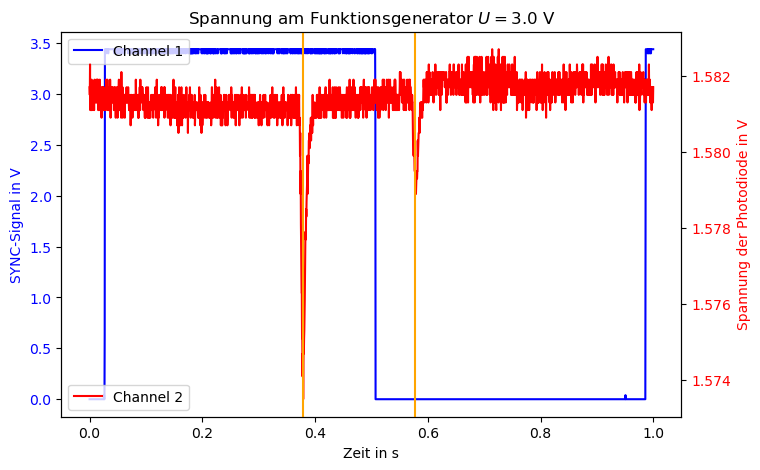

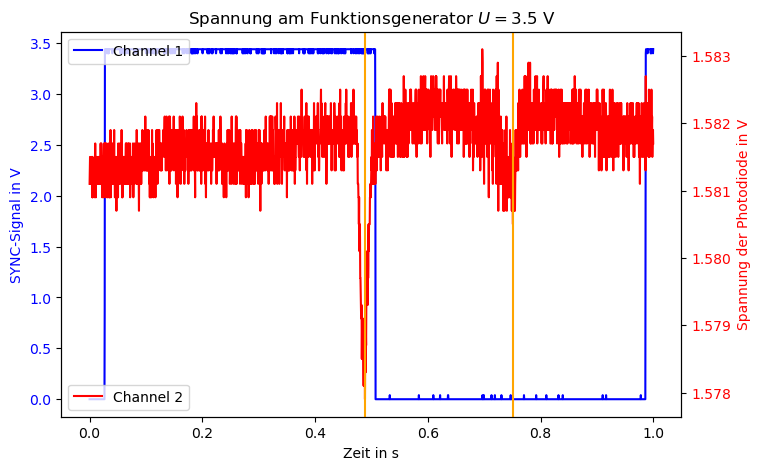

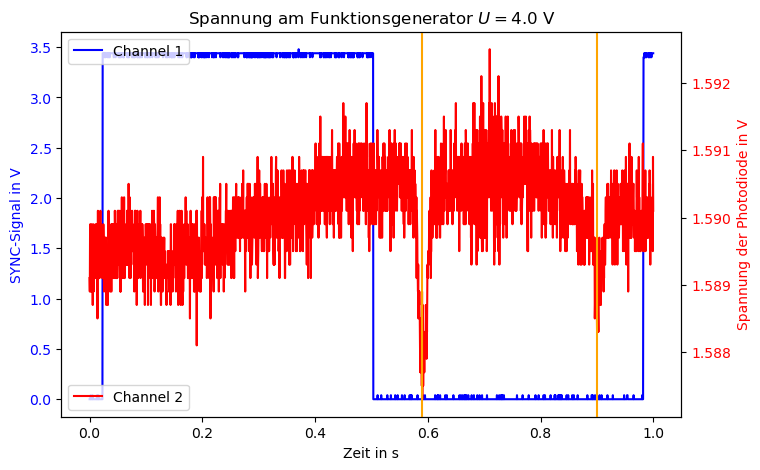

In [56]:
B1 = [40,35,30,25,20,15,10]
B2 = [10,15,20,30,35,40]
labels = [-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.5,1.0,1.5,2.0,3.0,3.5,4.0]
sweep = [Oszi(f'data/g_faktor/f_sweep/-{i}V') for i in B1] + [Oszi('data/g_faktor/f_sweep/-05V'),Oszi('data/g_faktor/f_sweep/05V')] + [Oszi(f'data/g_faktor/f_sweep/{i}V') for i in B2]

def find_flanke(y):
    '''Steigende Flanken finden, durch ersten Wert größer 3.'''
    indizes = []
    for i in range(len(y)):
        if y[i] > 3.0 and y[i-1] < 3.0:
            indizes.append(i)
    return np.array(indizes)

def peak_func(feq,U,I,height,prominence,width,cut=(0,1)):
    '''Nutze die zwei niedrigsten Peaks'''
    feq.plot(title=f'Spannung am Funktionsgenerator $U={U}$ V',xlabel='Zeit in s',ylabel1='SYNC-Signal in V',ylabel2='Spannung der Photodiode in V')

    # Daten auf den zu sehenden Sweep eingeschränkt.
    # Nutze die zwei niedrigsten Peaks.
    flanken = find_flanke(feq.ch1)
    t = feq.time[flanken[0]:flanken[1]]
    # ch1 = feq.ch1[flanken[0]:flanken[1]]
    ch2 = feq.ch2[flanken[0]:flanken[1]]
    peaks = find_peaks(-1*ch2,height=height,prominence=prominence,width=width)[0]
    # print(ch2[peaks])

    # Nutze zwei niedrigsten Peaks, die per array cut gewählt werden, welches die Indizes enthält...
    peaks = [peaks[cut[0]]] + [peaks[cut[1]]]

    for x in peaks:
        plt.axvline(x=t[x],c='orange')
    # print(ch2[peaks])

    # peaks enthält Indizes bezogen auf Einschränkung auf Sweep
    len = flanken[1] - flanken[0] # Anzahl der Zeit-Schritte in einem Sweep
    freq = np.linspace(500e3,10e6,len) # entsprechende Frequenzschritte

    B = const.mu_0*helmholtz(N,r,0.5*I)  # Helmholtz gibt H zurück, nicht B
    Berr = const.mu_0*helmholtz(N,r,abs(0.02*I)+0.05)

    # print('Spannung: ',U)
    # print(B*1e3)
    # print(Berr*1e3)

    # print(peaks)
    ferr = 50/(flanken[1]-flanken[0])*(10e6-500e3)

    plt.savefig(f'figures/frequenzsweep_{U}_V.pdf')

    return np.array([B,freq[peaks][0],freq[peaks][1],Berr,ferr])
    
peaks = []

peaks.append(peak_func(sweep[0],-4.0,-1.63,-1.577,0.001,30,cut=(0,1)))
peaks.append(peak_func(sweep[1],-3.5,-1.45,-1.569,0.002,20,cut=(0,1)))
peaks.append(peak_func(sweep[2],-3.0,-1.21,-1.559,0.002,10,cut=(0,2)))
peaks.append(peak_func(sweep[3],-2.5,-0.93,-1.5725,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[4],-2.0,-0.73,-1.564,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[5],-1.5,-0.53,-1.577,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[6],-1.0,-0.35,-1.577,0.005,10,cut=(0,1)))
peaks.append(peak_func(sweep[7],-0.5,-0.17,-1.577,0.005,10,cut=(0,1)))
peaks.append(peak_func(sweep[8],0.5,0.16,-1.577,0.005,10,cut=(0,1)))
peaks.append(peak_func(sweep[9],1.0,0.32,-1.577,0.005,10,cut=(0,1)))
peaks.append(peak_func(sweep[10],1.5,0.50,-1.577,0.005,10,cut=(0,1)))
peaks.append(peak_func(sweep[11],2.0,0.60,-1.577,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[12],3.0,1.03,-1.580,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[13],3.5,1.35,-1.581,0.001,10,cut=(0,1)))
peaks.append(peak_func(sweep[14],4.0,1.57,-1.5885,0.001,10,cut=(0,1)))

peaks = np.array(peaks).T

[-1.30280653 -1.15893832 -0.96711405 -0.5834655  -0.42361194 -0.27974373
 -0.13587553  0.12788285  0.2557657   0.3996339   0.47956069  0.82324584
  1.07901154  1.25485046]
[0.13203904 0.12628431 0.11861134 0.1032654  0.09687126 0.09111653
 0.0853618  0.08504209 0.09015741 0.09591214 0.09910921 0.11285661
 0.12308724 0.1301208 ]
g (85):  0.3415663845109837
error g:  0.0025589218490334772
r:  0.9996634142380091
p:  2.097747365090171e-20
g (87):  0.5116216120904292
error g:  0.0037989974149487946
r:  0.999669344281212
p:  1.88556057465145e-20


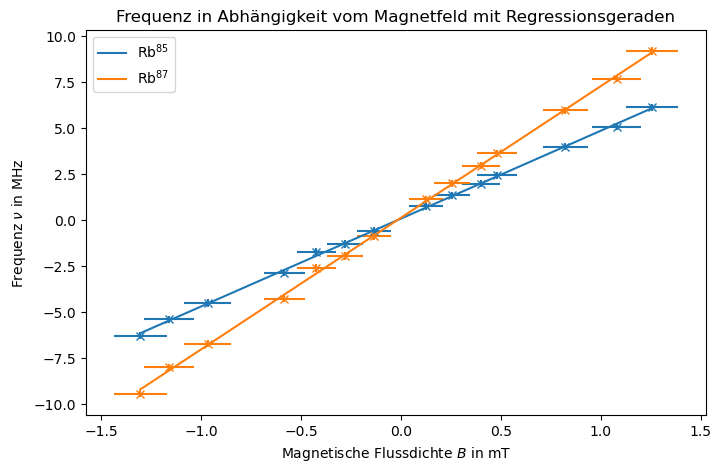

In [57]:
def lin(x,m,b):
    return m*x+b

def slope_to_g(slope):
    return slope*const.h/const.physical_constants['Bohr magneton'][0]

# Stimmt die Einheit des Magnetfeldes???
fig, ax = plt.subplots(figsize=(8,5))

# Entferne einen Wert und invertiere den ersten Teil der Geraden
B = peaks[0]
f1 = peaks[1]
f2 = peaks[2]
Berr = peaks[3]
ferr = peaks[4]
entf = 3
B = np.delete(B,[entf])
Berr = np.delete(Berr,[entf])
f1 = np.delete(f1,[entf])
f2 = np.delete(f2,[entf])
f1 = np.append(-1*f1[0:7],f1[7:])
f2 = np.append(-1*f2[0:7],f2[7:])
ferr = np.delete(ferr,[entf])

# Fehler für B aus Multimeter-Messung
# Fehler für Frequenz aus Abschätung von \pm 5 Zeitschhritten

plt.errorbar(B*1e3,f1*1e-6,xerr=Berr*1e3,yerr=ferr*1e-6,linestyle=' ',marker='x')
plt.errorbar(B*1e3,f2*1e-6,xerr=Berr*1e3,yerr=ferr*1e-6,linestyle=' ',marker='x')

print(B*1e3)
print(Berr*1e3)
# print(ferr)
# print(f2)

slope, intercept, rvalue, pvalue, slope_std = linregress(B,f1)
plt.plot(B*1e3,lin(B,slope,intercept)*1e-6,label='Rb$^{85}$',c='tab:blue')
print('g (85): ', slope_to_g(slope))
print('error g: ', slope_to_g(slope_std))
print('r: ',rvalue)
print('p: ',pvalue)


slope, intercept, rvalue, pvalue, slope_std = linregress(B,f2)
plt.plot(B*1e3,lin(B,slope,intercept)*1e-6,label='Rb$^{87}$',c='tab:orange')
print('g (87): ', slope_to_g(slope))
print('error g: ', slope_to_g(slope_std))
print('r: ',rvalue)
print('p: ',pvalue)

plt.xlabel('Magnetische Flussdichte $B$ in mT')
plt.ylabel(r'Frequenz $\nu$ in MHz')
plt.legend()
plt.title('Frequenz in Abhängigkeit vom Magnetfeld mit Regressionsgeraden')
plt.savefig('figures/frequenzsweep_regression.pdf')